In [1]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils import data
import os
from os import listdir
from os.path import join, abspath
import itertools
import re
import random
import time
from torch.autograd import Variable
from scipy.signal import tukey
from torch.utils import data
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore")


import json
import sqlalchemy as sal
import getpass
import pandas as pd
from urllib.request import urlopen
import pickle as pkl

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# torch.cuda.get_device_name(0)

In [3]:
torch.cuda.is_available()

False

# Get data from RDS


In [4]:
%%time
#parameters of the AWS database
endpoint = "capstone.clihskgj8i7s.us-west-2.rds.amazonaws.com"
user="group3"
db="db1"
#pw=getpass.getpass("Enter database password")
pw=open(r'C:\Users\rmartinez4\OneDrive - Illumina, Inc\Desktop\password.txt',"r").read().rstrip()

engine = sal.create_engine('postgresql://%s:%s@%s/%s' % (user, pw, endpoint, db))

# query="""
# select timestamp, station, total_flow
# from traffic_train
# ;
# """

query="""
select timestamp, station, avg_speed
from traffic_train
;
"""

query_data=pd.read_sql(query, engine)

print(query_data.shape)
query_data.head()

(16673264, 3)
Wall time: 6min 34s


,timestamp,station,avg_speed
0,2020-04-09 13:20:00,400714,67.0
1,2020-04-09 13:20:00,400715,63.6
2,2020-04-09 13:20:00,400717,64.8
3,2020-04-09 13:20:00,400723,63.5
4,2020-04-09 13:20:00,400743,70.4


In [9]:
print(query_data.timestamp.min(), query_data.timestamp.max())

2020-01-01 00:05:00 2020-06-30 00:00:00


In [10]:
len(query_data.station.unique())

320

In [68]:
query_data.isna().sum()

timestamp       0
station         0
avg_speed    1971
dtype: int64

In [12]:
# %%time
# # get a subset of the data
# list_ = list(query_data.station.unique()[:50])
# df = query_data[[i in list_ for i in query_data.station]]
# df.shape

In [14]:
# df.shape

# Data Preparation

- Data Augmentation: create more segments with a sliding window of 1 hour (12 data points)
- split into segments
- filter segments with: negative values

In [69]:
# filter out negative values in the segment and sequences with nan

def generate_segments(df, segment_length=24, window=1):
    
    cols = ['station','timestamp']
    
    df = df.set_index(cols).sort_values(by=cols)
    
    continous_time_series = []
    
    for s in df.index.unique(level=0):
        
        print(s)
        
        values = df.loc[s].values
                
        for i in range(len(values)-segment_length):
            
            arr = np.array(values[i:i+segment_length])
            time_series = torch.from_numpy(arr.reshape(segment_length,1))
                        
            # do not include if any value within the segment is less than zero or nan
            if any(time_series<0) | any(np.isnan(time_series)):
#                 print('Ignored segment {}'.format(time_series))
                continue
            
            continous_time_series.append(time_series)
                        
    return torch.stack(continous_time_series, 0)

In [70]:
%%time
df = query_data.copy()
c_time_series = generate_segments(df)
c_time_series.shape

400001
400017
400030
400040
400045
400052
400057
400059
400065
400069
400073
400084
400085
400088
400096
400097
400100
400104
400109
400122
400147
400148
400149
400158
400160
400168
400172
400174
400178
400185
400201
400206
400209
400213
400221
400222
400227
400236
400238
400240
400246
400253
400257
400258
400268
400274
400278
400280
400292
400296
400298
400330
400336
400343
400353
400372
400394
400400
400414
400418
400429
400435
400436
400440
400449
400457
400461
400464
400479
400485
400499
400507
400508
400514
400519
400528
400545
400560
400563
400567
400581
400582
400586
400637
400643
400648
400649
400654
400664
400665
400668
400673
400677
400687
400688
400690
400700
400709
400713
400714
400715
400717
400723
400743
400750
400760
400772
400790
400792
400794
400799
400804
400822
400823
400828
400832
400837
400842
400863
400869
400873
400895
400904
400907
400911
400916
400922
400934
400951
400952
400953
400964
400965
400970
400971
400973
400995
400996
401014
401129
401154
401163
401167

torch.Size([16618280, 24, 1])

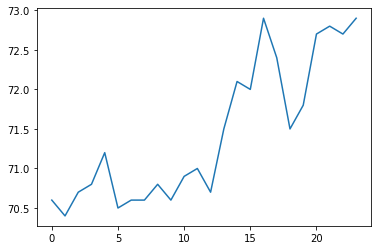

In [78]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.plot(np.array(c_time_series[33].reshape(1,24)[0]))

In [72]:
# %%time
# # find idx for segments with negative values and remove
# n_segments = c_time_series.shape[0]
# idx_to_keep = [i for i in range(n_segments) if all(c_time_series[i,:,:]>=0) and not any(c_time_series[i,:,:].isnan())]
# len(idx_to_keep)

In [73]:
# c_time_series = c_time_series[idx_to_keep, :, :]
# c_time_series.shape

In [74]:
# check there are no nan
torch.any(c_time_series.isnan(),dim=1).sum()

tensor(0)

In [75]:
torch.any(~c_time_series.isnan(),dim=1).sum()

tensor(16618280)

In [76]:
filename = r'C:\Users\rmartinez4\Box\Personal Git\dse-capstone\seq2seq_example\data_traffic\traffic_bayArea_station_allStations_12pts_SPEED.pkl'

In [77]:
%%time
# save data

with open(filename, "wb") as fout:
    pkl.dump(c_time_series, fout, protocol=pkl.HIGHEST_PROTOCOL)

Wall time: 8.5 s


# Read Saved Data

In [4]:
# filename = '../data_traffic/traffic_bayArea_station_mediumSize_12pts.pkl'
# filename = '../data_traffic/traffic_bayArea_station_400001.pkl'
# filename = '../data_traffic/traffic_bayArea_station_allStations_12pts_withNaNs.pkl'
filename = '../data_traffic/traffic_bayArea_station_allStations_12pts_SPEED.pkl'


In [5]:
%%time

# read tensor
with open(filename, "rb") as fout:
    c_time_series = pkl.load(fout)

Wall time: 7.19 s


In [6]:
c_time_series.shape

torch.Size([16618280, 24, 1])

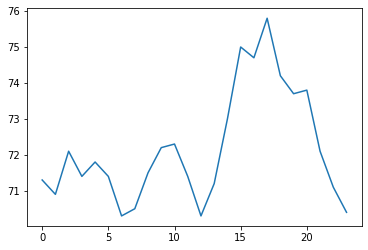

In [8]:
plt.plot(c_time_series[16663].reshape(1,24)[0].tolist())

In [240]:
# c_time_series[5]

## Remove segments with nan values

In [8]:
# number to be removed
torch.any(c_time_series.isnan(),dim=1).sum()

tensor(47304)

In [9]:
# number to be kept
torch.any(~c_time_series.isnan(),dim=1).sum()

tensor(16665584)

In [10]:
%%time

mask_idxs = [idx for idx, val in enumerate(np.array(~torch.any(c_time_series.isnan(),dim=1))) if val]
c_time_series = c_time_series[mask_idxs, :, :]

Wall time: 8.12 s


In [11]:
c_time_series.shape

torch.Size([16618280, 24, 1])

In [9]:
# check no more nan segments are present
torch.any(c_time_series.isnan(),dim=1).sum()

tensor(0)

In [21]:
# c_time_series[3]

# Generate Train and Test Datasets

In [10]:
def scale_data(data_x, data_y, out_pos = 0, return_current_avg_std = False):
    """ 
    Arg:
        data_x: features
        data_y: labels
        out_pos: the position of feature of which average and stand deviation will be returned.
    returns:
        1. Normalized features and labels
        2. Average and standard deviation of the selected feature.
    """
    avg = data_x[:,:,out_pos].mean()
    std = data_x[:,:,out_pos].std()
#     c_avg = data_x[:,:,1].mean()
#     c_std = data_x[:,:,1].std()
    for i in range(data_x.shape[-1]):
        data_x[:,:,i] = (data_x[:,:,i] - data_x[:,:,i].mean())/data_x[:,:,i].std()
    data_y = (data_y-avg)/std
    if return_current_avg_std:
        return data_x, data_y, (avg, std)  
#         return data_x, data_y, (avg, std), (c_avg, c_std)   
    else:
        return data_x, data_y, (avg, std)

class Dataset(data.Dataset):
    def __init__(self, X, Y, lst_index, output_steps, position_embedding = (False)):
        """
        Args:
            lst_index: indexes of observations in the dataset.
            output_steps: Forecasting Horizon.
        """
        self.X = X[lst_index]
        self.Y = Y[lst_index]
        self.output_steps = output_steps
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index][:self.output_steps]
        return x, y

In [11]:
%%time

sample_size = c_time_series.shape[0]
segment_size = c_time_series.shape[1]
pred_size = int(segment_size/2)

test_size = sample_size // 4
train_valid_size = test_size * 3
training_size = test_size * 2
validation_size = test_size * 1

# X_train = c_time_series[:train_valid_size,:pred_size,:]
# Y_train = c_time_series[:train_valid_size,pred_size:,:]
# sample_size, pred_length, feature_count = X_train.shape

X_test = c_time_series[training_size:training_size+test_size,:pred_size,:]
Y_test = c_time_series[training_size:training_size+test_size,pred_size:,:]

X_all = c_time_series[:train_valid_size+test_size,:pred_size,:]
Y_all = c_time_series[:train_valid_size+test_size,pred_size:,:]

X, Y, (avg, std) = scale_data(X_all, Y_all, out_pos = 0, return_current_avg_std = True)

Wall time: 6.78 s


In [12]:
# print(X_train.shape, Y_train.shape)
# print(X_test.shape, Y_test.shape)
print(X_all.shape, Y_all.shape)

# print(sample_size, pred_length, feature_count)

print(test_size, train_valid_size, training_size, validation_size)

torch.Size([16618280, 12, 1]) torch.Size([16618280, 12, 1])
4154570 12463710 8309140 4154570


In [ ]:
Y[3]

# Train Neural Network

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            input_dim: the dimension of input sequences.
            hidden_dim: number hidden units.
            num_layers: number of encode layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional = True, dropout = dropout_rate, batch_first = True)
        
    def forward(self, source):
        """
        Args:
            source: input tensor(batch_size*input dimension)
        Return:
            outputs: Prediction
            concat_hidden: hidden states
        """
        outputs, hidden = self.lstm(source)
        return outputs, hidden
    
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            output_dim: the dimension of output sequences.
            hidden_dim: number hidden units.
            num_layers: number of code layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Decoder, self).__init__()
        
        # Since the encoder is bidirectional, decoder has double hidden size
        self.lstm = nn.LSTM(output_dim, hidden_dim*2, num_layers = num_layers, 
                            dropout = dropout_rate, batch_first = True)
        
        self.out = nn.Linear(hidden_dim*2, output_dim)
      
    def forward(self, x, hidden):
        """
        Args:
            x: prediction from previous prediction.
            hidden: hidden states from previous cell.
        Returns:
            1. prediction for current step.
            2. hidden state pass to next cell.
        """
        output, hidden = self.lstm(x, hidden)   
        prediction = self.out(output.float())
        return prediction, hidden     
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        """
        Args:
            encoder: Encoder object.
            decoder: Decoder object.
            device: 
        """
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target_tensor):
        """
        Args:
            source: input tensor.
            target_length: forecasting steps.
        Returns:
            total prediction
        """
        batch_size = source.size(0) 
        input_length = source.size(1) 
        target_length = target_tensor.shape[1]
        output_dim = target_tensor.shape[-1]
        encoder_hidden = (torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device),
                          torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device))
        encoder_output, encoder_hidden = self.encoder(source)
        
        # Concatenate the hidden states of both directions.
        num_layers = int(encoder_hidden[0].shape[0]/2)
        h = torch.cat([encoder_hidden[0][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[0][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        c = torch.cat([encoder_hidden[1][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[1][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        concat_hidden = (h, c)
        
        
        outputs = torch.zeros(batch_size, target_length, output_dim).to(self.device)
        decoder_output = torch.zeros((batch_size, 1, output_dim), device = self.device)
        decoder_hidden = concat_hidden
        
        for t in range(target_length):  
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden)
            outputs[:,t:t+1,:] = decoder_output
        return outputs

In [14]:
def run_epoch_train(model, data_generator, model_optimizer, criterion):
    """
    Args:
        model: RNN model.
        data_generator: data.DataLoader object.
        model_optimizer: optimizer.
        criterion: loss function
    Returns:
        Root Mean Square Error on Training Dataset
    """
    MSE = []
    for x, y in data_generator:
        # The input shape for nn.conv1d should sequence_length * batch_size * #features
        input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
        model_optimizer.zero_grad()
        loss = 0
        output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
        num_iter = output.size(0)
        for ot in range(num_iter):
            loss += criterion(output[ot], target_tensor[ot])
        MSE.append(loss.item()/num_iter)
        loss.backward()
        model_optimizer.step()
    
    return round(np.sqrt(np.mean(MSE)), 5)
 

def run_epoch_eval(model, data_generator, criterion, return_pred = False):
    """
    Args:
        model: CNN model.
        data_generator: data.DataLoader object.
        criterion: loss function
    Returns:
        Root Mean Square Error on evaluation datasets.
    """
    with torch.no_grad():
        MSE = []
        preds = []
        for x, y in data_generator:
            input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
            loss = 0
            output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
            
            preds.append(output.cpu().detach().numpy())
            num_iter = output.size(0)
            
            for ot in range(num_iter):
                loss += criterion(output[ot], target_tensor[ot])
            MSE.append(loss.item()/num_iter)
            
    if return_pred == True:
        preds =  np.concatenate(preds).squeeze(-1)
        return round(np.sqrt(np.mean(MSE)), 5), preds
    else:
        return round(np.sqrt(np.mean(MSE)), 5)


def train_model(model, X, Y, learning_rate, output_steps, batch_size, train_idx, valid_idx, test_idx, test=False, return_pred=False):
    # Initialize the model and define optimizer, learning rate decay and criterion
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma=0.8)
    criterion = nn.MSELoss()
    
    # Split dataset into training set, validation set and test set.
    train_rmse, train_set = [], Dataset(X, Y, train_idx, output_steps)
    valid_rmse, valid_set = [], Dataset(X, Y, valid_idx, output_steps)
    if test:
        test_rmse, test_set = [], Dataset(X, Y, test_idx, output_steps)
    
    min_loss = 1000
    best_model = 0
    best_preds = 0
    min_valid_loss = 1000
    
    for i in tqdm(range(200)):
        start = time.time()
        scheduler.step()
        train_generator = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
        valid_generator = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)
        if test:
            test_generator = data.DataLoader(test_set, batch_size = batch_size, shuffle = False)
 
        model.train()
        train_rmse.append(run_epoch_train(model, train_generator, optimizer, criterion))
            
        model.eval()
        rmse, predictions = run_epoch_eval(model,  valid_generator, criterion, return_pred = True)
        valid_rmse.append(rmse)
        
        if test:
            if return_pred:
                t_rmse, test_predictions = run_epoch_eval(model, test_generator, criterion, return_pred = True)
            else:
                t_rmse = run_epoch_eval(model, test_generator, criterion, return_pred = False)
            test_rmse.append(t_rmse)
        
        if valid_rmse[-1] < min_loss:
            min_loss = valid_rmse[-1]
            best_model = model
            min_valid_loss = valid_rmse[-1]
            best_preds = predictions
            min_valid_loss = valid_rmse[-1]
            
        if (len(train_rmse) > 15 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break
            
    end = time.time()       
    print(("Epoch %d:"%(i+1)), ("Loss: %f; "%train_rmse[-1]),("valid_loss: %f; "%valid_rmse[-1]), 
          ("Time: %f; "%round(end - start,5)))

    if test:
        if return_pred:
            return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse, test_predictions
        return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse
    return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss

In [39]:
learning_rate = 0.0001
dropout_rate = 0.8
num_layers = 1
hidden_dim = 64

input_size = 1
output_size = 1

In [40]:
%%time

input_steps = segment_size
output_steps = segment_size
# input_size = 2

train_idx = list(range(training_size))
valid_idx = list(range(training_size, train_valid_size))
test_idx = list(range(train_valid_size, train_valid_size + test_size))

Wall time: 750 ms


In [ ]:
%%time

encoder = Encoder(input_size, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_size, hidden_dim, num_layers, dropout_rate)
model = Seq2Seq(encoder, decoder, device).to(device)

In [41]:
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 128, batch_first=True, dropout=0.6, bidirectional=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 256, batch_first=True, dropout=0.6)
    (out): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [42]:
# print number of parameters for the model
sum(p.numel() for p in model.parameters() if p.requires_grad)

399617

In [43]:
# %%time

# model, loss, preds, min_valid_loss, test_rmse = train_model(
#     model, X, Y, learning_rate, output_steps = output_steps, batch_size = 64,
#     train_idx = train_idx, valid_idx = valid_idx, test_idx = test_idx, test=True)

# print({
#     'learning_rate': learning_rate,
#     'dropout_rate': dropout_rate,
#     'num_layers':num_layers,
#     'hidden_dim': hidden_dim,
# #     'model_state_dict': model.state_dict(),
# #     'loss': loss,
#     'min_valid_loss': min_valid_loss,
# #     'preds':preds,
# })

In [44]:
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 128, batch_first=True, dropout=0.6, bidirectional=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 256, batch_first=True, dropout=0.6)
    (out): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
torch.save(model, filename.split('.')[0]+'_model.pth')

# Read Saved Model

In [16]:
# find model with lowest test RMSE
hyper_param_fp = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\hyper_param_tunning'
for fn in [i for i in os.listdir(hyper_param_fp) if 'results_dict' in i]:
    rd = pkl.load(open(join(hyper_param_fp, fn), "rb"))
    print(fn, rd['test_rmse'][-1])
    

results_dict_0.0001_0.2_64.pkl 0.47107
results_dict_0.0001_0.4_320.pkl 0.47269
results_dict_0.0001_0.4_384.pkl 0.47529
results_dict_0.0001_0.8_64.pkl 0.4709
results_dict_0.001_0.4_128.pkl 0.47801
results_dict_0.001_0.4_192.pkl 0.48069
results_dict_0.001_0.4_256.pkl 0.47692
results_dict_0.001_0.6_384.pkl 0.48279
results_dict_0.001_0.8_448.pkl 0.48396
results_dict_0.01_0.4_192.pkl 0.47322
results_dict_0.01_0.4_256.pkl 0.47497
results_dict_0.01_0.4_320.pkl 0.47393
results_dict_0.01_0.6_256.pkl 0.47578
results_dict_0.01_0.8_384.pkl 0.47678
results_dict_0.1_0.2_64.pkl 86.71295
results_dict_0.1_0.4_192.pkl 184.73519
results_dict_0.1_0.6_256.pkl 164.24811
results_dict_0.1_0.8_128.pkl 168.7669


In [45]:
# model_path = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\dataaccess_station_400001\traffic_bayArea_station_400001_model.pth'
# model_path = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\scratch\model_outputs\dataaccess_mediumSize_50station\traffic_bayArea_station_mediumSize_12pts_model.pth'
# model_path = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\multiple_batch_size\model_outputs\128\station_400001\trained_model.pth'

model_path = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\hyper_param_tunning\trained_model_0.0001_0.8_64.pth'

encoder = Encoder(input_size, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_size, hidden_dim, num_layers, dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)

In [46]:
# %%time

# # load state dict
# model_dict = torch.load(model_path, map_location=torch.device('cpu'))
# model.load_state_dict(model_dict)


In [47]:
%%time

# load model object
model_obj = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(model_obj.state_dict())


Wall time: 8.04 ms


<All keys matched successfully>

In [48]:
model_obj.state_dict().keys()

odict_keys(['encoder.lstm.weight_ih_l0', 'encoder.lstm.weight_hh_l0', 'encoder.lstm.bias_ih_l0', 'encoder.lstm.bias_hh_l0', 'encoder.lstm.weight_ih_l0_reverse', 'encoder.lstm.weight_hh_l0_reverse', 'encoder.lstm.bias_ih_l0_reverse', 'encoder.lstm.bias_hh_l0_reverse', 'decoder.lstm.weight_ih_l0', 'decoder.lstm.weight_hh_l0', 'decoder.lstm.bias_ih_l0', 'decoder.lstm.bias_hh_l0', 'decoder.out.weight', 'decoder.out.bias'])

In [49]:
torch.__version__

'1.8.1+cpu'

In [50]:
 model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 64, batch_first=True, dropout=0.8, bidirectional=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 128, batch_first=True, dropout=0.8)
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [51]:
device

device(type='cpu')

# Predict on Test Data

In [52]:
%%time

# make sure to update batch size

test_rmse, test_set = [], Dataset(X, Y, test_idx, output_steps)
test_generator = data.DataLoader(test_set, batch_size = 512, shuffle = False)

criterion = nn.MSELoss()
model.eval()
t_rmse, preds = run_epoch_eval(model, test_generator, criterion, return_pred = True)

Wall time: 21min 35s


In [53]:
t_rmse

0.4596

In [54]:
preds[13]

array([0.1647356 , 0.14187135, 0.13341533, 0.1300721 , 0.12927939,
       0.12961663, 0.13026969, 0.13066249, 0.13042916, 0.12938218,
       0.12746613, 0.12471204], dtype=float32)

# Visualize Predictions

In [166]:
# need X_test, Y_test, preds

In [55]:
std

tensor(7.2992, dtype=torch.float64)

In [56]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [57]:
def unscale_data(scaled_data, avg, std):
    data = scaled_data * std + avg
    return data

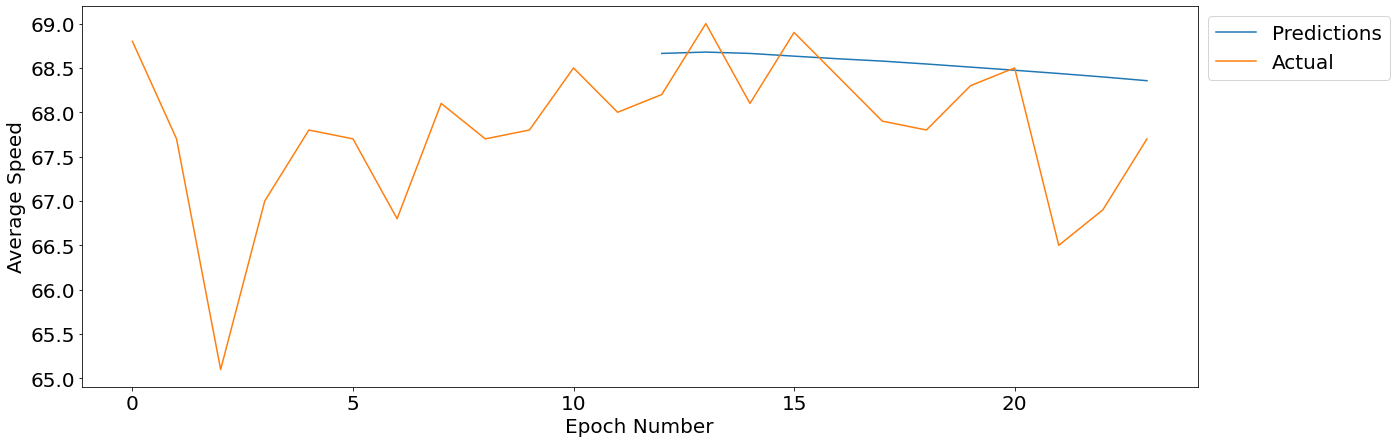

In [73]:
# first example for 3 hours
plt.figure(figsize=(20,7))
index_to_plot = 30144
plt.plot(np.concatenate(([np.nan]*pred_size, unscale_data(preds[index_to_plot], float(avg), float(std)))))
plt.plot(torch.cat([unscale_data(X_test[:,:,0][index_to_plot],float(avg), float(std)), Y_test[:,:,0][index_to_plot]]))
plt.legend(['Predictions', 'Actual'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Segment Index")
plt.ylabel("Average Speed")
plt.rcParams.update({'font.size': 20})


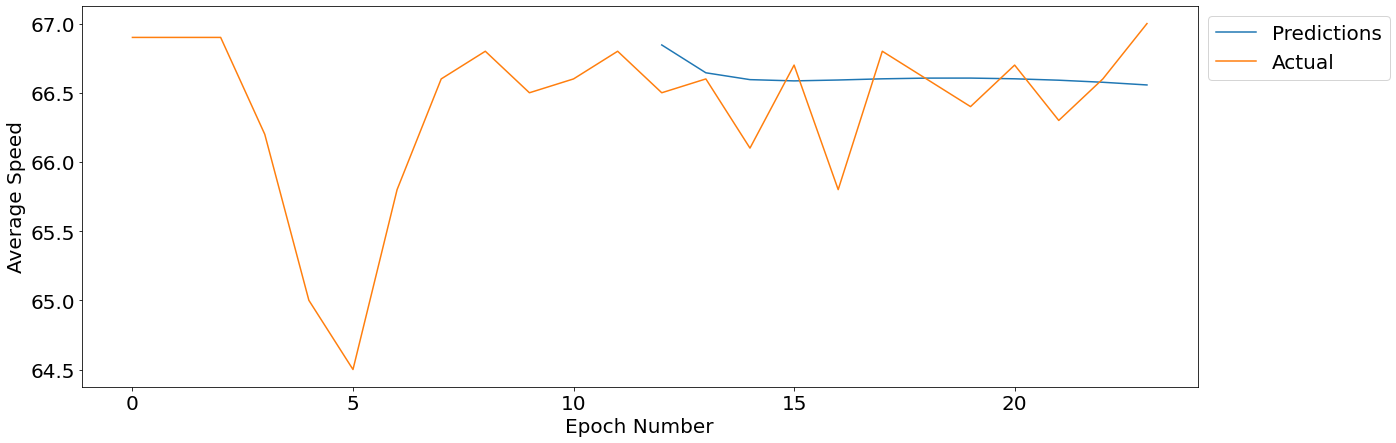

In [87]:
# second example for 3 hours
plt.figure(figsize=(20,7))
index_to_plot = 1124830
plt.plot(np.concatenate(([np.nan]*pred_size, unscale_data(preds[index_to_plot], float(avg), float(std)))))
plt.plot(torch.cat([unscale_data(X_test[:,:,0][index_to_plot],float(avg), float(std)), Y_test[:,:,0][index_to_plot]]))
plt.legend(['Predictions', 'Actual'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Segment Index")
plt.ylabel("Average Speed")
plt.rcParams.update({'font.size': 20})

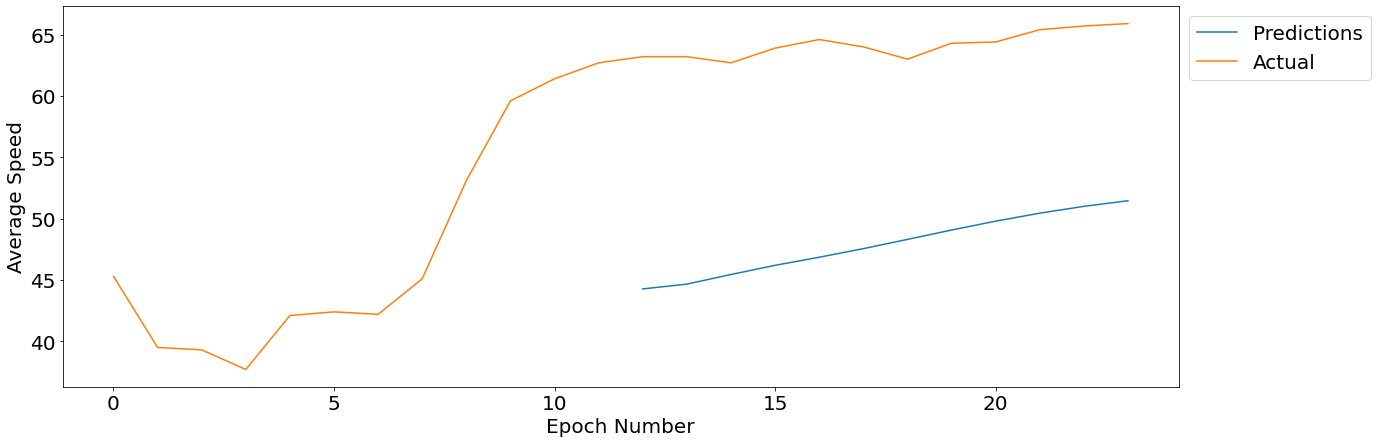

In [61]:
# third example for 3 hours
plt.figure(figsize=(20,7))
index_to_plot = 112457
plt.plot(np.concatenate(([np.nan]*pred_size, unscale_data(preds[index_to_plot], float(avg), float(std)))))
plt.plot(torch.cat([unscale_data(X_test[:,:,0][index_to_plot],float(avg), float(std)), Y_test[:,:,0][index_to_plot]]))
plt.legend(['Predictions', 'Actual'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Segment Index")
plt.ylabel("Average Speed")
plt.rcParams.update({'font.size': 20})

In [19]:
def unscale_data_lossFunc(scaled_data, avg, std):
#     data = scaled_data * std + avg
    data = scaled_data * std    
    return data

In [36]:
# results_fp = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\dataaccess_station_400001\traffic_bayArea_station_400001_results_dict.pkl'
# results_fp = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\dataaccess_mediumSize_50station\traffic_bayArea_station_mediumSize_12pts_results_dict.pkl'
# results_fp = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\multiple_batch_size\model_outputs\128\station_400001\results_dict.pkl'

results_fp = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\hyper_param_tunning\results_dict_0.0001_0.8_64.pkl'

rd = pkl.load(open(results_fp, "rb"))

print(rd)

defaultdict(<class 'list'>, {'train_rmse': [0.49479, 0.48043, 0.47583, 0.47358, 0.47189, 0.47116, 0.4706, 0.47011, 0.46967, 0.46903, 0.46877, 0.46853, 0.46828, 0.46806, 0.46765, 0.46749, 0.46734, 0.46716, 0.46701, 0.46673, 0.46663, 0.46651, 0.46641, 0.46627], 'val_rmse': [0.41153, 0.40889, 0.40682, 0.40729, 0.40559, 0.40535, 0.40526, 0.40444, 0.4046, 0.40491, 0.40447, 0.40397, 0.40462, 0.40549, 0.40385, 0.40382, 0.40396, 0.40362, 0.40348, 0.40381, 0.40415, 0.40429, 0.40395, 0.40357], 'test_rmse': [0.48217, 0.47623, 0.47412, 0.47379, 0.47263, 0.47122, 0.47194, 0.47112, 0.47163, 0.47181, 0.47142, 0.4713, 0.47169, 0.47199, 0.47114, 0.47086, 0.47187, 0.47081, 0.47125, 0.47112, 0.47088, 0.47127, 0.47097, 0.47107]})


Test RMSE: 3.438425990371157 (scaled), 0.47107 (unscaled)


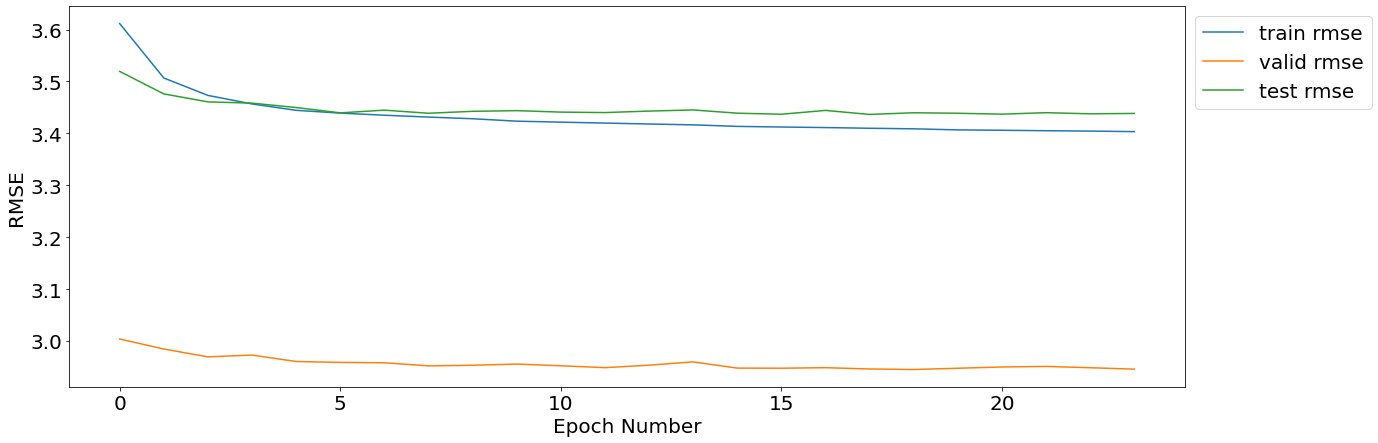

In [37]:
train_rmse = unscale_data_lossFunc(np.array(rd['train_rmse']),float(avg), float(std))
valid_rmse = unscale_data_lossFunc(np.array(rd['val_rmse']),float(avg), float(std))
test_rmse = unscale_data_lossFunc(np.array(rd['test_rmse']),float(avg), float(std))

plt.figure(figsize=(20,7))
plt.plot(train_rmse)
plt.plot(valid_rmse)
plt.plot(test_rmse)

plt.legend(['train rmse', 'valid rmse', 'test rmse'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Epoch Number")
plt.ylabel("RMSE")
plt.rcParams.update({'font.size': 20})

print('Test RMSE: {} (scaled), {} (unscaled)'.format(test_rmse[-1], rd['test_rmse'][-1]) )

# Multi-GPU testing

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils import data
import os
from os import listdir
from os.path import join, abspath
import time
from torch.autograd import Variable
from torch.utils import data
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


from datetime import datetime

import pickle as pkl


############# Seq2seq functions

def scale_data(data_x, data_y, out_pos = 0, return_current_avg_std = False):
    """ 
    Arg:
        data_x: features
        data_y: labels
        out_pos: the position of feature of which average and stand deviation will be returned.
    returns:
        1. Normalized features and labels
        2. Average and standard deviation of the selected feature.
    """
    avg = data_x[:,:,out_pos].mean()
    std = data_x[:,:,out_pos].std()
#     c_avg = data_x[:,:,1].mean()
#     c_std = data_x[:,:,1].std()
    for i in range(data_x.shape[-1]):
        data_x[:,:,i] = (data_x[:,:,i] - data_x[:,:,i].mean())/data_x[:,:,i].std()
    data_y = (data_y-avg)/std
    if return_current_avg_std:
        return data_x, data_y, (avg, std)  
#         return data_x, data_y, (avg, std), (c_avg, c_std)   
    else:
        return data_x, data_y, (avg, std)

class Dataset(data.Dataset):
    def __init__(self, X, Y, lst_index, output_steps, position_embedding = (False)):
        """
        Args:
            lst_index: indexes of observations in the dataset.
            output_steps: Forecasting Horizon.
        """
        self.X = X[lst_index]
        self.Y = Y[lst_index]
        self.output_steps = output_steps
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index][:self.output_steps]
        return x, y
        

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            input_dim: the dimension of input sequences.
            hidden_dim: number hidden units.
            num_layers: number of encode layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional = True, dropout = dropout_rate, batch_first = True)
        
    def forward(self, source):
        """
        Args:
            source: input tensor(batch_size*input dimension)
        Return:
            outputs: Prediction
            concat_hidden: hidden states
        """
        outputs, hidden = self.lstm(source)
        return outputs, hidden
    
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            output_dim: the dimension of output sequences.
            hidden_dim: number hidden units.
            num_layers: number of code layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Decoder, self).__init__()
        
        # Since the encoder is bidirectional, decoder has double hidden size
        self.lstm = nn.LSTM(output_dim, hidden_dim*2, num_layers = num_layers, 
                            dropout = dropout_rate, batch_first = True)
        
        self.out = nn.Linear(hidden_dim*2, output_dim)
      
    def forward(self, x, hidden):
        """
        Args:
            x: prediction from previous prediction.
            hidden: hidden states from previous cell.
        Returns:
            1. prediction for current step.
            2. hidden state pass to next cell.
        """
        output, hidden = self.lstm(x, hidden)   
        prediction = self.out(output.float())
        return prediction, hidden     
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        """
        Args:
            encoder: Encoder object.
            decoder: Decoder object.
            device: 
        """
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target_tensor):
        """
        Args:
            source: input tensor.
            target_length: forecasting steps.
        Returns:
            total prediction
        """
        batch_size = source.size(0) 
        input_length = source.size(1) 
        target_length = target_tensor.shape[1]
        output_dim = target_tensor.shape[-1]
        encoder_hidden = (torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device),
                          torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device))
        encoder_output, encoder_hidden = self.encoder(source)
        
        # Concatenate the hidden states of both directions.
        num_layers = int(encoder_hidden[0].shape[0]/2)
        h = torch.cat([encoder_hidden[0][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[0][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        c = torch.cat([encoder_hidden[1][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[1][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        concat_hidden = (h, c)
        
        
        outputs = torch.zeros(batch_size, target_length, output_dim).to(self.device)
        decoder_output = torch.zeros((batch_size, 1, output_dim), device = self.device)
        decoder_hidden = concat_hidden
        
        for t in range(target_length):  
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden)
            outputs[:,t:t+1,:] = decoder_output
        return outputs


def run_epoch_train(model, data_generator, model_optimizer, criterion):
    """
    Args:
        model: RNN model.
        data_generator: data.DataLoader object.
        model_optimizer: optimizer.
        criterion: loss function
    Returns:
        Root Mean Square Error on Training Dataset
    """
    MSE = []
    for x, y in data_generator:
        # The input shape for nn.conv1d should sequence_length * batch_size * #features
        input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
        model_optimizer.zero_grad()
        loss = 0
        output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
        num_iter = output.size(0)
        for ot in range(num_iter):
            loss += criterion(output[ot], target_tensor[ot])
        MSE.append(loss.item()/num_iter)
        loss.backward()
        model_optimizer.step()
    
    return round(np.sqrt(np.mean(MSE)), 5)
 

def run_epoch_eval(model, data_generator, criterion, return_pred = False):
    """
    Args:
        model: CNN model.
        data_generator: data.DataLoader object.
        criterion: loss function
    Returns:
        Root Mean Square Error on evaluation datasets.
    """
    with torch.no_grad():
        MSE = []
        preds = []
        for x, y in data_generator:
            input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
            loss = 0
            output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
            preds.append(output.cpu().detach().numpy())
            num_iter = output.size(0)
            
            for ot in range(num_iter):
                loss += criterion(output[ot], target_tensor[ot])
            MSE.append(loss.item()/num_iter)
            
    if return_pred == True:
        preds =  np.concatenate(preds).squeeze(-1)
        return round(np.sqrt(np.mean(MSE)), 5), preds
    else:
        return round(np.sqrt(np.mean(MSE)), 5)


def train_model(model, X, Y, learning_rate, output_steps, batch_size, train_idx, valid_idx, test_idx, test=False, return_pred=False):
    # Initialize the model and define optimizer, learning rate decay and criterion
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma=0.8)
    criterion = nn.MSELoss()
    
    # Split dataset into training set, validation set and test set.
    train_rmse, train_set = [], Dataset(X, Y, train_idx, output_steps)
    valid_rmse, valid_set = [], Dataset(X, Y, valid_idx, output_steps)
    if test:
        test_rmse, test_set = [], Dataset(X, Y, test_idx, output_steps)
    
    min_loss = 1000
    best_model = 0
    best_preds = 0
    min_valid_loss = 1000
    
    # for i in tqdm(range(200)):
    for i in range(200):
        
        print(i, datetime.now())
        
        start = time.time()
        scheduler.step()
        train_generator = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
        valid_generator = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)
        if test:
            test_generator = data.DataLoader(test_set, batch_size = batch_size, shuffle = False)
 
        model.train()
        train_rmse.append(run_epoch_train(model, train_generator, optimizer, criterion))
            
        model.eval()
        rmse, predictions = run_epoch_eval(model,  valid_generator, criterion, return_pred = True)
        valid_rmse.append(rmse)
        
        if test:
            if return_pred:
                t_rmse, test_predictions = run_epoch_eval(model, test_generator, criterion, return_pred = True)
            else:
                t_rmse = run_epoch_eval(model, test_generator, criterion, return_pred = False)
            test_rmse.append(t_rmse)
        
        if valid_rmse[-1] < min_loss:
            min_loss = valid_rmse[-1]
            best_model = model
            min_valid_loss = valid_rmse[-1]
            best_preds = predictions
            min_valid_loss = valid_rmse[-1]
            
        if (len(train_rmse) > 15 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break
            
    end = time.time()       
    print(("Epoch %d:"%(i+1)), ("Loss: %f; "%train_rmse[-1]),("valid_loss: %f; "%valid_rmse[-1]), 
          ("Time: %f; "%round(end - start,5)))

    if test:
        if return_pred:
            return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse, test_predictions
        return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse
    return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss


############# Main

print('Code started', datetime.now())

# base_dir = r'C:\Users\rmartinez4\Box\Personal Git\dse-capstone\seq2seq_example\data_traffic'
base_dir = r'C:\Users\rmartinez4\Box\Personal Git\dse-capstone\seq2seq_example\data_traffic'

filename = 'traffic_bayArea_station_400001.pkl'

# read tensor
with open(join(base_dir, filename), "rb") as fout:
    c_time_series = pkl.load(fout)

sample_size = c_time_series.shape[0]
segment_size = c_time_series.shape[1]
pred_size = int(segment_size/2)

test_size = sample_size // 5
train_valid_size = test_size * 4
training_size = test_size * 7//2
validation_size = test_size * 1//2

print(' sample_size', sample_size, '\n',
      'train_valid_size', train_valid_size, '\n',
      'training_size', training_size, '\n',
      'validation_size', validation_size, '\n',
      'test_size', test_size)

X_all = c_time_series[:train_valid_size+test_size,:pred_size,:]
Y_all = c_time_series[:train_valid_size+test_size,pred_size:,:]

X, Y, (avg, std) = scale_data(X_all, Y_all, out_pos = 0, return_current_avg_std = True)


learning_rate = 0.01
dropout_rate = 0.6
num_layers = 1
hidden_dim = 128

input_steps = segment_size
output_steps = segment_size
input_size = 1
output_size = 1

train_idx = list(range(training_size))
valid_idx = list(range(training_size, train_valid_size))
test_idx = list(range(train_valid_size, train_valid_size + test_size))

encoder = Encoder(input_size, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_size, hidden_dim, num_layers, dropout_rate)

# to enable multi GPU training
# rank = dist.get_rank()
# world_size = dist.get_world_size()
# print('rank {} and world size {}'.format(rank, world_size))

# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '12355'
# dist.init_process_group("gloo", rank=0, world_size=2)


# init_method="/some_file"
init_method='env://'
dist.init_process_group(
   "gloo",
   rank=0,
   init_method=init_method,
   world_size=2)

print('Hello')

model = Seq2Seq(encoder, decoder, rank).to(rank)
model = DDP(model, device_ids=[rank])

model, loss, preds, min_valid_loss, test_rmse = train_model(
    model, X, Y, learning_rate, output_steps = output_steps, batch_size = 64,
    train_idx = train_idx, valid_idx = valid_idx, test_idx = test_idx, test=True)

results_dict = {
    'learning_rate': learning_rate,
    'dropout_rate': dropout_rate,
    'num_layers':num_layers,
    'hidden_dim': hidden_dim,
    # 'model_state_dict': model.state_dict(),
    'train_rmse': loss[0],
    'valid_rmse': loss[1],
    'test_rmse': test_rmse,
    'min_valid_loss': min_valid_loss
    # 'preds':preds
}


# read saved model
# model = torch.load(r'C:\Users\rmartinez4\Box\Personal Git\dse-capstone\seq2seq_example\Nautilus\models\traffic_bayArea_station_400001_model.pth', map_location=torch.device('cpu'))

# save results dict and model
# file_id = filename.split('.')[0]
# with open(base_dir + file_id + '_results_dict.pkl', 'wb') as handle:
# # with open(join(base_dir, file_id + '_results_dict.pkl'), 'wb') as handle:
#     pkl.dump(results_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

# torch.save(model, base_dir + file_id + '_model.pth')
# torch.save(model, join(base_dir, file_id + '_model.pth'))




cpu
Code started 2021-04-20 13:50:33.063228
 sample_size 327725 
 train_valid_size 262180 
 training_size 229407 
 validation_size 32772 
 test_size 65545


RuntimeError: No rendezvous handler for env://